In [1]:
import json
import os
import matplotlib.pyplot as plt
import numpy as np
from bakeoff.posteriors import invgamma_posterior
import matplotlib.pyplot as plt

import pymc as pm
import pytensor.tensor as pt
import pytensor
pytensor.config.cxx = '/usr/bin/clang++'


We have to construct a method to transform the latent parameters into the constrained space for tracking.

In [2]:
def exp_transform(vals):
    mus = vals[0]
    stds = vals[1]
    mean = np.exp(mus + 0.5 * stds**2)
    std = np.sqrt((np.exp(stds**2) - 1) * np.exp(2 * mus + stds**2))
    return mean, std

In [35]:
mu_like = 0.0
sigma_like = 2.0
alpha_prior, beta_prior = 4.0, 2.9
n_samples = 50
data = np.random.normal(mu_like, sigma_like, n_samples)

with pm.Model() as model:
    sigmasq = pm.InverseGamma('sigmasq', alpha=alpha_prior, beta=beta_prior)
    likelihood = pm.LogNormal('likelihood', mu=mu_like, sigma=pt.sqrt(sigmasq), observed=data)

    advi = pm.ADVI(random_seed=20)
    tracker = pm.callbacks.Tracker(
        mean = advi.approx.mean.eval,
        std = advi.approx.std.eval
    )

    approx = advi.fit(50_000, callbacks=[tracker],
                      obj_n_mc=1000,
                      obj_optimizer=pm.adam(learning_rate=5e-2))


Output()

Finished [100%]: Average Loss = nan


In [36]:
# let's check whether the tracker is tracking constrained
# or unconstrained parameters
with model:
    # Draw samples from the approximation
    samples = approx.sample(10000)
    print("Sample mean:", samples.posterior['sigmasq'].mean())
    print("Tracker mean:", tracker['mean'][-1])
    print('Transformed tracker mean:', np.exp(tracker['mean'][-1] + 0.5 * tracker['std'][-1]**2))
    print('Sample std:', samples.posterior['sigmasq'].std())
    print('Tracker std:', tracker['std'][-1])
    print('Transformed tracker std:', np.sqrt((np.exp(tracker['std'][-1]**2) - 1) * np.exp(2 * tracker['mean'][-1] + tracker['std'][-1]**2)))

Sample mean: <xarray.DataArray 'sigmasq' ()> Size: 8B
array(1.82109282)
Tracker mean: [0.56827882]
Transformed tracker mean: [1.82647583]
Sample std: <xarray.DataArray 'sigmasq' ()> Size: 8B
array(0.47856728)
Tracker std: [0.26118774]
Transformed tracker std: [0.48530595]


If we plot the un-transformed tracked values against the truth, we can see that they don't line up.

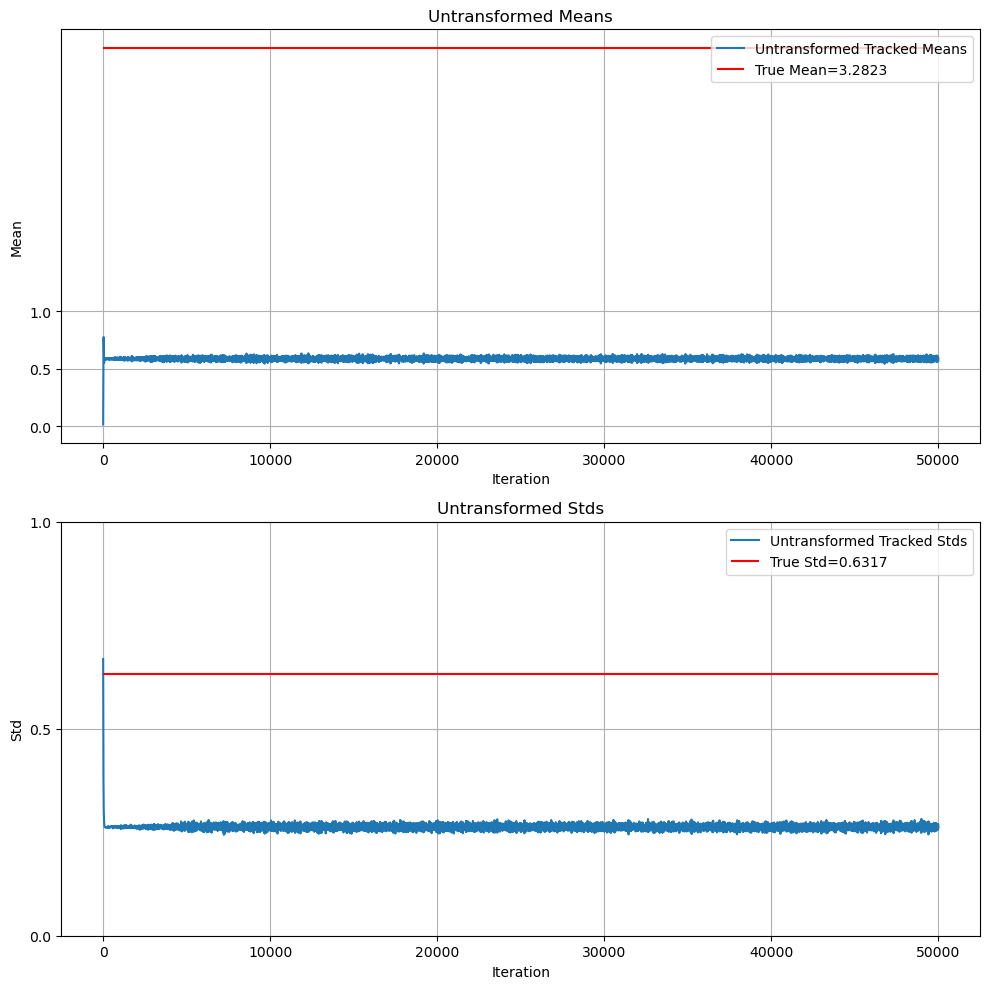

In [37]:
posts = invgamma_posterior(data, mu_like, alpha_0=alpha_prior, beta_0=beta_prior)
true_mean, true_std = posts['mean_post'], posts['std_post']
means, stds = np.array(tracker['mean']), np.array(tracker['std'])

transformed_means, transformed_stds = np.apply_along_axis(exp_transform, 0, np.array([means, stds]))

fig, ax = plt.subplots(2, 1, figsize=(10,10))
ax[0].plot(means, label='Untransformed Tracked Means')
ax[0].hlines(true_mean, 0, len(means), colors='r', label='True Mean=%.4f' % true_mean)
ax[0].set_title('Untransformed Means')
ax[0].set_xlabel('Iteration')
ax[0].set_ylabel('Mean')
ax[0].set_yticks(np.arange(0, 1.5, 0.5))
ax[0].legend()
ax[0].grid()

ax[1].plot(stds, label='Untransformed Tracked Stds')
ax[1].hlines(true_std, 0, len(stds), colors='r', label='True Std=%.4f' % true_std)
ax[1].set_title('Untransformed Stds')
ax[1].set_xlabel('Iteration')
ax[1].set_ylabel('Std')
ax[1].set_yticks(np.arange(0, 1.5, 0.5))
ax[1].grid()
ax[1].legend()

plt.tight_layout()
plt.show()

Now we can plot the transformed means and stds.

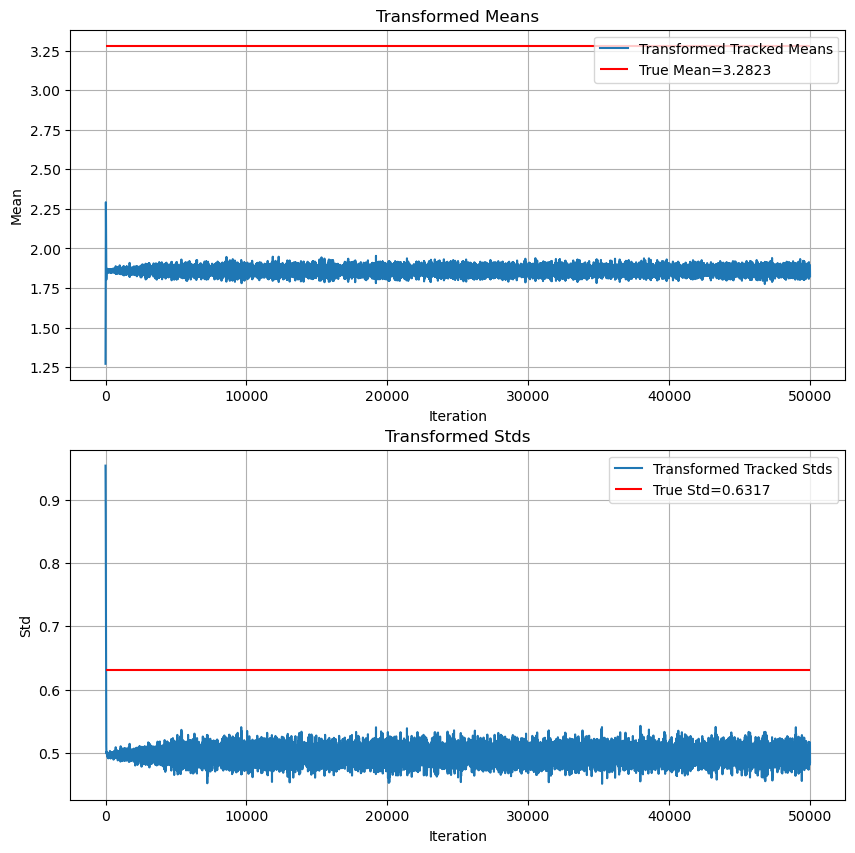

In [38]:

fig, ax = plt.subplots(2, 1, figsize=(10,10))
ax[0].plot(transformed_means, label='Transformed Tracked Means')
ax[0].hlines(true_mean, 0, len(transformed_means), colors='r', label='True Mean=%.4f' % true_mean)
ax[0].set_title('Transformed Means')
ax[0].set_xlabel('Iteration')
ax[0].set_ylabel('Mean')
ax[0].legend()
ax[0].grid()

ax[1].plot(transformed_stds, label='Transformed Tracked Stds')
ax[1].hlines(true_std, 0, len(transformed_stds), colors='r', label='True Std=%.4f' % true_std)
ax[1].set_title('Transformed Stds')
ax[1].set_xlabel('Iteration')
ax[1].set_ylabel('Std')
ax[1].grid()
ax[1].legend()
plt.show()

As a sanity check, let's look at the posterior pdf to check that it is overlapping the true posterior distribution well.

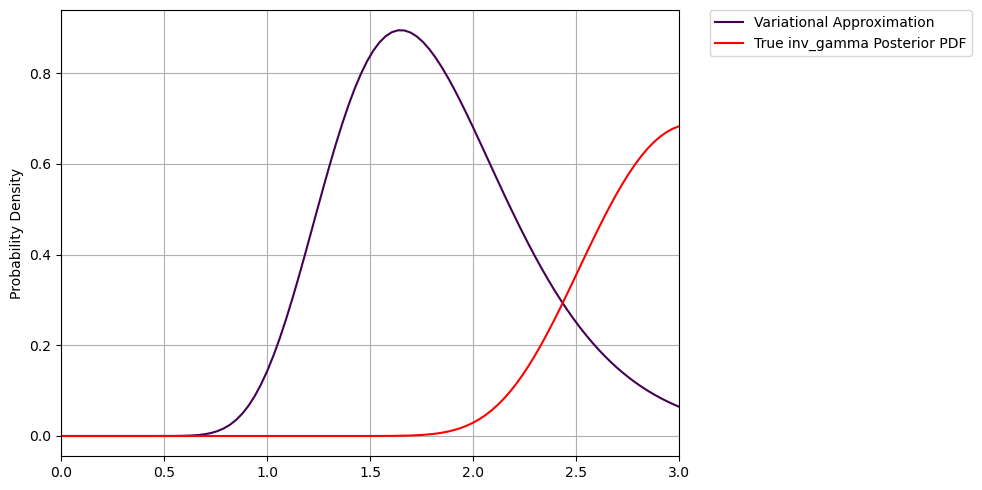

In [39]:
fig = plt.figure(figsize=(10, 5))


def lognormal_pdf(y, mu, sigma):
    # y must be > 0
    y = np.asarray(y)
    pdf = np.zeros_like(y)
    mask = y > 0
    pdf[mask] = (1 / (y[mask] * sigma * np.sqrt(2 * np.pi))) * \
        np.exp(-0.5 * ((np.log(y[mask]) - mu) / sigma) ** 2)
    return pdf

from bakeoff.plotting import true_post
params = (posts['alpha_post'], posts['beta_post'])
xlim = (0, 3)
spacing = 100
dist_type = 'inv_gamma'
x, y = true_post(dist_type, params, xlim, spacing)
colors = plt.cm.viridis(np.linspace(0, 1, 3))

var_y = lognormal_pdf(x, means[-1], stds[-1])
plt.plot(x, var_y, label=f'Variational Approximation', color=colors[0])

plt.plot(x, y, label=f'True {dist_type} Posterior PDF', color='red')
plt.ylabel('Probability Density')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.grid()
plt.xlim(xlim)
plt.tight_layout()

plt.show()
